# Deep Learning Preprocessing Pipeline for Flight Delay Data

This notebook builds upon the base preprocessing pipeline to create features specifically optimized for deep learning models such as neural networks. Deep learning models typically require specialized preprocessing including proper normalization, embedding-friendly encodings for categorical variables, and structured data formats compatible with deep learning frameworks.

## Key Processing Steps:
1. Loading the base preprocessed data
2. Feature engineering specific to deep learning models
3. Advanced encoding for categorical variables (embeddings)
4. Data normalization (standardization)
5. Sequence generation for RNNs and LSTMs
6. Data batching and formatting for deep learning frameworks
7. Time-based validation strategy
8. Exporting the processed data for DL model training

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import OrdinalEncoder  


# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
BASE_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'base_preprocessed_flights.csv')
DL_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'dl_ready_flights')
DL_MODEL_PATH = path.join(project_root, 'models', 'dl')

# Create directories if they don't exist
os.makedirs(os.path.dirname(DL_PROCESSED_PATH), exist_ok=True)
os.makedirs(DL_MODEL_PATH, exist_ok=True)

print(f"Base processed data path: {BASE_PROCESSED_PATH}")
print(f"DL processed data path: {DL_PROCESSED_PATH}")
print(f"DL model path: {DL_MODEL_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Base processed data path: c:\Users\Electronica Care\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv
DL processed data path: c:\Users\Electronica Care\Forecasting_Flights-DataScience\data\processed\dl_ready_flights
DL model path: c:\Users\Electronica Care\Forecasting_Flights-DataScience\models\dl
Libraries and paths configured.


In [2]:
# Function to load data in chunks
def load_processed_data(file_path, chunk_size=500000):
    """
    Generator function to load preprocessed data in chunks
    """
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        yield chunk

In [3]:
# Inspect the data
first_chunk = next(load_processed_data(BASE_PROCESSED_PATH))

print(f"Data shape of first chunk: {first_chunk.shape}")
print("\nColumns and data types:")
for col in first_chunk.columns:
    print(f"- {col}: {first_chunk[col].dtype}")

print("\nSample data (first 5 rows):")
display(first_chunk.head())

Data shape of first chunk: (500000, 41)

Columns and data types:
- FL_DATE: datetime64[ns]
- AIRLINE: object
- AIRLINE_DOT: object
- AIRLINE_CODE: object
- DOT_CODE: int64
- FL_NUMBER: int64
- ORIGIN: object
- ORIGIN_CITY: object
- DEST: object
- DEST_CITY: object
- CRS_DEP_TIME: int64
- DEP_TIME: int64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- CANCELLATION_CODE: float64
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- DELAY_DUE_CARRIER: float64
- DELAY_DUE_WEATHER: float64
- DELAY_DUE_NAS: float64
- DELAY_DUE_SECURITY: float64
- DELAY_DUE_LATE_AIRCRAFT: float64
- YEAR: int64
- QUARTER: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object

Sample data (first 5 rows):


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",715,711,0.0,19.0,1210.0,1443.0,4.0,901,1447.0,0.0,0,NaN,0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,2019,1,1,9,2,1,0,11,Morning
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",1280,1274,0.0,9.0,2123.0,2232.0,38.0,1395,2310.0,0.0,0,NaN,0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,2022,4,11,19,5,4,1,21,Evening
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,NaN,0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,2022,3,7,22,4,3,0,9,Morning
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",969,968,0.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,NaN,0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,2023,1,3,6,0,2,0,16,Afternoon
4,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,665,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,NaN,0,60.0,54.0,36.0,181.0,141.0,0.0,0.0,0.0,0.0,2019,3,7,31,2,3,0,10,Morning


## Feature Engineering Specific to Deep Learning Models

Deep learning models require specific preprocessing approaches. Let's define functions to prepare data for neural networks:

1. Proper categorical encodings for embeddings
2. Feature normalization
3. Sequence data preparation for recurrent networks
4. Structured representations for tabular data

In [4]:
# Create DL-specific features
def create_dl_features(df):
    """
    Create features specifically useful for deep learning models
    """
    df_featured = df.copy()
    
    # ======== TEMPORAL FEATURES FOR SEQUENTIAL MODELS ========
    
    # Sort by date and time if available
    if 'FL_DATE' in df_featured.columns and 'DEP_TIME' in df_featured.columns:
        df_featured = df_featured.sort_values(['FL_DATE', 'DEP_TIME'])
    
    # Create normalized time features (better for neural networks)
    if 'MONTH' in df_featured.columns:
        # Normalize month to [0,1]
        df_featured['MONTH_NORM'] = (df_featured['MONTH'] - 1) / 11
    
    if 'DAY_OF_MONTH' in df_featured.columns:
        # Normalize day to [0,1]
        df_featured['DAY_OF_MONTH_NORM'] = (df_featured['DAY_OF_MONTH'] - 1) / 30
    
    if 'DAY_OF_WEEK' in df_featured.columns:
        # Normalize day of week to [0,1]
        df_featured['DAY_OF_WEEK_NORM'] = (df_featured['DAY_OF_WEEK'] - 1) / 6
    
    if 'DEP_HOUR' in df_featured.columns:
        # Normalize hour to [0,1]
        df_featured['DEP_HOUR_NORM'] = df_featured['DEP_HOUR'] / 23
    
    # Create sine and cosine features for cyclical time variables
    # These are particularly useful for neural networks to understand cyclical patterns
    if 'MONTH' in df_featured.columns:
        df_featured['MONTH_SIN'] = np.sin(2 * np.pi * df_featured['MONTH'] / 12)
        df_featured['MONTH_COS'] = np.cos(2 * np.pi * df_featured['MONTH'] / 12)
    
    if 'DAY_OF_WEEK' in df_featured.columns:
        df_featured['DAY_OF_WEEK_SIN'] = np.sin(2 * np.pi * df_featured['DAY_OF_WEEK'] / 7)
        df_featured['DAY_OF_WEEK_COS'] = np.cos(2 * np.pi * df_featured['DAY_OF_WEEK'] / 7)
    
    if 'DEP_HOUR' in df_featured.columns:
        df_featured['DEP_HOUR_SIN'] = np.sin(2 * np.pi * df_featured['DEP_HOUR'] / 24)
        df_featured['DEP_HOUR_COS'] = np.cos(2 * np.pi * df_featured['DEP_HOUR'] / 24)
    
    # ======== AGGREGATED FEATURES FOR CONTEXT ========
    # Note: In a full pipeline, these would be pre-computed from historical data
    # Here we're calculating them within the chunk as an approximation
    
    if 'ORIGIN' in df_featured.columns:
        # Airport busy level - compute average daily flights per origin
        airport_flights = df_featured.groupby('ORIGIN').size().reset_index(name='ORIGIN_FLIGHTS')
        df_featured = df_featured.merge(airport_flights, on='ORIGIN', how='left')
        
        # Normalize the airport flight count
        max_flights = df_featured['ORIGIN_FLIGHTS'].max()
        if max_flights > 0:  # Avoid division by zero
            df_featured['ORIGIN_FLIGHTS_NORM'] = df_featured['ORIGIN_FLIGHTS'] / max_flights
    
    if 'OP_CARRIER' in df_featured.columns:
        # Carrier size - compute total flights per carrier
        carrier_flights = df_featured.groupby('OP_CARRIER').size().reset_index(name='CARRIER_FLIGHTS')
        df_featured = df_featured.merge(carrier_flights, on='OP_CARRIER', how='left')
        
        # Normalize the carrier flight count
        max_flights = df_featured['CARRIER_FLIGHTS'].max()
        if max_flights > 0:  # Avoid division by zero
            df_featured['CARRIER_FLIGHTS_NORM'] = df_featured['CARRIER_FLIGHTS'] / max_flights
    
    # ======== SEQUENTIAL FEATURES ========
    
    # Code for creating sequential features will be in a separate function
    
    return df_featured

In [5]:
# Create label encoders for categorical variables (for embeddings)
def create_label_encoders(df, categorical_cols=None):
    """
    Create label encoders for categorical variables to be used in embeddings
    """
    if categorical_cols is None:
        # Identify categorical columns automatically
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Create a dictionary to store encoders
    encoders = {}
    vocab_sizes = {}
    
    # Create label encoder for each categorical column
    for col in categorical_cols:
        if col not in df.columns:
            continue
        
        # Create and fit the label encoder
        encoder = LabelEncoder()
        encoder.fit(df[col].astype(str).fillna('UNKNOWN'))
        encoders[col] = encoder
        
        # Store vocabulary size (number of unique categories + 1 for unknown)
        vocab_sizes[col] = len(encoder.classes_) + 1
    
    return encoders, vocab_sizes, categorical_cols

In [6]:
# Apply label encoders and create embedding-ready data
def apply_label_encodings(df, encoders, categorical_cols):
    """
    Apply label encoders and prepare data for embeddings
    """
    df_encoded = df.copy()
    
    # Apply encoding to each categorical column
    for col, encoder in encoders.items():
        if col in df_encoded.columns:
            # Convert to string and fill NAs
            col_data = df_encoded[col].astype(str).fillna('UNKNOWN')
            
            # Handle values not seen during training
            unique_vals = set(col_data.unique())
            known_vals = set(encoder.classes_)
            unknown_vals = unique_vals - known_vals
            
            if unknown_vals:
                # Replace unknown values with a known value (e.g., 'UNKNOWN')
                for val in unknown_vals:
                    col_data = col_data.replace(val, 'UNKNOWN')
            
            # Transform using the encoder
            try:
                df_encoded[f'{col}_ENCODED'] = encoder.transform(col_data)
            except:
                # If transformation fails, use a default value
                print(f"Error encoding {col}, using default values")
                df_encoded[f'{col}_ENCODED'] = 0
            
            # Drop the original column (we keep the encoded version for embeddings)
            df_encoded = df_encoded.drop(col, axis=1)
    
    return df_encoded

In [7]:
# Normalize numeric features for deep learning
def normalize_features_dl(df, exclude_cols=None, scaler=None):
    """
    Normalize numeric features for neural networks
    """
    if exclude_cols is None:
        exclude_cols = []
    
    df_norm = df.copy()
    
    # Get numeric columns excluding those in exclude_cols
    numeric_cols = df_norm.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Fit or transform with scaler
    if scaler is None:
        # First call - fit a new scaler
        scaler = StandardScaler()
        df_norm[numeric_cols] = scaler.fit_transform(df_norm[numeric_cols])
    else:
        # Subsequent calls - use the fitted scaler
        df_norm[numeric_cols] = scaler.transform(df_norm[numeric_cols])
    
    return df_norm, scaler

In [8]:
# Create sequence data for RNN/LSTM models
def create_sequence_data(df, seq_length=10, time_col='FL_DATE', group_cols=None, target_col='DEP_DELAY'):
    """
    Create sequences for RNN/LSTM models
    
    This function creates sequences of data by grouping by specified columns
    and ordering by time. Each sequence will have seq_length steps.
    """
    if group_cols is None:
        # Default grouping by origin airport and carrier
        group_cols = ['ORIGIN', 'OP_CARRIER']
    
    # Filter group_cols to include only columns that exist
    group_cols = [col for col in group_cols if col in df.columns]
    
    # Ensure we have at least one grouping column
    if not group_cols:
        raise ValueError("No valid grouping columns found")
    
    # Sort by group and time
    if time_col in df.columns:
        df_sorted = df.sort_values(group_cols + [time_col])
    else:
        # If no time column, just use the existing order
        df_sorted = df
    
    # Lists to store sequences and targets
    X_sequences = []
    y_values = []
    
    # Group by the specified columns
    for _, group in df_sorted.groupby(group_cols):
        # Skip if group is too small
        if len(group) < seq_length + 1:
            continue
        
        # Extract features (exclude target and time column)
        features = group.drop([target_col], axis=1)
        if time_col in features.columns:
            features = features.drop([time_col], axis=1)
        
        # Extract target
        targets = group[target_col].values
        
        # Create sequences
        for i in range(len(group) - seq_length):
            X_sequences.append(features.iloc[i:i+seq_length].values)
            y_values.append(targets[i+seq_length])
    
    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_values = np.array(y_values)
    
    return X_sequences, y_values

In [9]:
# Time-based train-test-validation split for deep learning
def time_based_split_dl(df, date_col='FL_DATE', test_size=0.2, val_size=0.1):
    """
    Create a time-based split for deep learning models
    """
    if date_col not in df.columns:
        raise ValueError(f"{date_col} not found in dataframe")
    
    # Sort by date
    df_sorted = df.sort_values(date_col)
    
    # Determine split points
    n_samples = len(df_sorted)
    test_start_idx = int(n_samples * (1 - test_size))
    val_start_idx = int(n_samples * (1 - test_size - val_size))
    
    # Split data
    train_data = df_sorted.iloc[:val_start_idx]
    val_data = df_sorted.iloc[val_start_idx:test_start_idx]
    test_data = df_sorted.iloc[test_start_idx:]
    
    print(f"Train set: {len(train_data):,} rows from {train_data[date_col].min()} to {train_data[date_col].max()}")
    print(f"Validation set: {len(val_data):,} rows from {val_data[date_col].min()} to {val_data[date_col].max()}")
    print(f"Test set: {len(test_data):,} rows from {test_data[date_col].min()} to {test_data[date_col].max()}")
    
    return train_data, val_data, test_data

In [10]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

def select_important_features(df, target_col='DEP_DELAY', date_col='FL_DATE', num_features=25):
    """
    Select top `num_features` using Random Forest feature importance on full dataset.
    Always includes `target_col` and `date_col` in the output.
    """
    print(f"Selecting top {num_features} features on full dataset ({len(df):,} rows)...")

    # Drop rows with NaN in target
    df_model = df.dropna(subset=[target_col])

    # Separate target and features
    X = df_model.drop(columns=[target_col])
    y = df_model[target_col]

    # Use only numeric columns
    X_numeric = X.select_dtypes(include=[np.number])

    # Drop columns with NaNs (or fill them)
    if X_numeric.isnull().any().any():
        print("⚠️ Found NaNs in numeric columns. Filling with column medians...")
        X_numeric = X_numeric.fillna(X_numeric.median())

    # Build and fit model
    rf = RandomForestRegressor(
        n_estimators=50,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_numeric, y)

    # Feature importance ranking
    importances = rf.feature_importances_
    ranked = pd.Series(importances, index=X_numeric.columns).sort_values(ascending=False)
    top_features = ranked.head(num_features).index.tolist()

    # Ensure target and date columns are included
    mandatory_cols = [target_col, date_col]
    for col in mandatory_cols:
        if col not in top_features and col in df_model.columns:
            top_features.append(col)

    print(f"✅ Final selected features: {top_features}")

    return df_model[top_features]


## Execute the DL Preprocessing Pipeline

Now we'll run the DL preprocessing pipeline on our base preprocessed data. For deep learning, we'll create both:
1. A standard tabular dataset for feedforward neural networks
2. Sequence data for RNN/LSTM models

In [11]:
# def drop_90pct_missing_per_column(df, threshold=0.5):
#     """
#     For each column with more than `threshold` fraction of missing values,
#     drop 90% of the missing rows (randomly).
#     """
#     for col in df.columns:
#         if df[col].isnull().mean() > threshold:
#             # Get indices with NaNs
#             nan_indices = df[df[col].isnull()].index
#             # Keep 10% of those NaNs, drop the rest
#             keep_size = int(len(nan_indices) * 0.1)
#             keep_indices = np.random.choice(nan_indices, size=keep_size, replace=False)
#             drop_indices = nan_indices.difference(keep_indices)
#             df = df.drop(index=drop_indices)
#     return df


In [12]:
def process_chunk_dl(chunk, encoders=None, categorical_cols=None, scaler=None, exclude_from_scaling=None):
    """
    Apply DL preprocessing to a chunk of base preprocessed data.
    
    Returns:
        chunk_dl: Transformed DataFrame
        encoders: Dict of fitted encoders
        categorical_cols: List of encoded categorical columns
        scaler: Fitted scaler object
    """
    # 1. Create DL-specific features
    chunk_dl = create_dl_features(chunk)

    # 2. Detect categorical columns if not passed
    if categorical_cols is None:
        categorical_cols = chunk_dl.select_dtypes(include=['object', 'category']).columns.tolist()

    # 3. Handle encoding
    if encoders is None:
        encoders = {}

    for col in categorical_cols:
        if col in chunk_dl.columns:
            chunk_dl[col] = chunk_dl[col].fillna('Unknown')
            reshaped = chunk_dl[col].astype(str).values.reshape(-1, 1)

            if col not in encoders:
                encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                try:
                    chunk_dl[col] = encoder.fit_transform(reshaped).astype(int)
                    encoders[col] = encoder
                except Exception as e:
                    print(f"Error fitting encoder on {col}, using fallback. Reason: {e}")
                    chunk_dl[col] = -1
            else:
                try:
                    chunk_dl[col] = encoders[col].transform(reshaped).astype(int)
                except Exception as e:
                    print(f"Error encoding {col}, using default values. Reason: {e}")
                    chunk_dl[col] = -1
        else:
            print(f"Warning: {col} not found in current chunk.")

    # 4. Normalize numeric features (exclude ID/time/categorical columns if needed)
    chunk_dl, scaler = normalize_features_dl(chunk_dl, exclude_from_scaling, scaler)

    return chunk_dl, encoders, categorical_cols, scaler


In [13]:
def prepare_dl_dataset(input_file, output_dir, chunk_size=500000, max_rows=600000):
    """
    Process and save up to `max_rows` rows of DL-ready data from `input_file`,
    prioritizing rows that help predict flight delays (non-zero delays + diverse coverage).
    """
    encoders = None
    categorical_cols = None
    scaler = None

    os.makedirs(output_dir, exist_ok=True)
    tabular_output = os.path.join(output_dir, 'dl_tabular_data.csv')
    encoders_output = os.path.join(output_dir, 'dl_encoders.pkl')
    scaler_output = os.path.join(output_dir, 'dl_scaler.pkl')

    saved_rows = 0
    all_data = []

    print(f"📦 Starting DL preprocessing from {input_file}...")

    for i, chunk in enumerate(load_processed_data(input_file, chunk_size=chunk_size)):
        if saved_rows >= max_rows:
            break

        start_time = datetime.now()

        # Preprocess
        processed_chunk, encoders, categorical_cols, scaler = process_chunk_dl(
            chunk, encoders, categorical_cols, scaler
        )

        if 'DEP_DELAY' not in processed_chunk.columns or 'FL_DATE' not in processed_chunk.columns:
            print("⚠️ Skipping chunk due to missing critical columns.")
            continue

        # Step 1: Prioritize delayed flights (DEP_DELAY > 15 minutes)
        delayed_flights = processed_chunk[processed_chunk['DEP_DELAY'] > 15]

        # Step 2: Also include a balanced number of non-delayed flights
        ontime_flights = processed_chunk[processed_chunk['DEP_DELAY'] <= 15]

        # Sample proportionally to avoid overfitting on delayed flights
        sample_size = min(max_rows - saved_rows, len(delayed_flights) + len(ontime_flights))
        delayed_sample = delayed_flights.sample(frac=0.6, random_state=42)
        ontime_sample = ontime_flights.sample(frac=0.4, random_state=42)

        balanced_sample = pd.concat([delayed_sample, ontime_sample]).sample(frac=1, random_state=42)

        if sample_size > 0:
            selected_rows = balanced_sample.iloc[:sample_size]
            all_data.append(selected_rows)
            saved_rows += len(selected_rows)

        end_time = datetime.now()
        print(f"✅ Chunk {i+1}: Total saved: {saved_rows:,} rows | Time: {(end_time - start_time).total_seconds():.2f}s")

    # Final data assembly
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.iloc[:max_rows]  # Ensure cap
    final_df.to_csv(tabular_output, index=False)

    # Save encoders and scaler
    with open(encoders_output, 'wb') as f:
        pickle.dump((encoders, categorical_cols), f)
    with open(scaler_output, 'wb') as f:
        pickle.dump(scaler, f)

    print("\n🎉 DL preprocessing complete!")
    print(f"📊 Final rows saved: {len(final_df):,}")
    print(f"🗂 File: {tabular_output}")
    print(f"🔐 Encoders saved to: {encoders_output}")
    print(f"📏 Scaler saved to: {scaler_output}")

    return encoders, categorical_cols, scaler


In [ ]:
# Execute the DL preprocessing pipeline
encoders, categorical_cols, scaler = prepare_dl_dataset(BASE_PROCESSED_PATH, DL_PROCESSED_PATH)

📦 Starting DL preprocessing from c:\Users\Electronica Care\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv...
✅ Chunk 1: Total saved: 200,080 rows | Time: 4.62s


In [ ]:
# Verify the output file and create sample sequences
try:
    # Define paths
    tabular_output = os.path.join(DL_PROCESSED_PATH, 'dl_tabular_data.csv')
    
    # Read a sample of the processed data
    dl_sample = pd.read_csv(tabular_output, nrows=10000)
    print(f"DL processed data shape: {dl_sample.shape}")
    
    print("\nColumns in DL processed data:")
    for col in dl_sample.columns:
        print(f"- {col}: {dl_sample[col].dtype}")
    
    print("\nSample of DL processed data:")
    display(dl_sample.head())
    
    # Convert date column back to datetime if needed
    if 'FL_DATE' in dl_sample.columns:
        dl_sample['FL_DATE'] = pd.to_datetime(dl_sample['FL_DATE'])
    
    # Create a small sequence dataset as an example
    print("\nCreating sample sequences for RNN/LSTM models...")
    X_seq, y_seq = create_sequence_data(dl_sample, seq_length=5)
    
    print(f"Sequence data shape: {X_seq.shape}")
    print(f"Target data shape: {y_seq.shape}")
    print("Sample sequence:")
    display(X_seq[0])
    
except Exception as e:
    print(f"Error verifying output: {e}")

DL processed data shape: (10000, 33)

Columns in DL processed data:
- ARR_DELAY: float64
- DELAY_DUE_NAS: float64
- TAXI_OUT: float64
- TAXI_IN: float64
- DELAY_DUE_CARRIER: float64
- DIVERTED: float64
- DEP_TIME: float64
- CRS_DEP_TIME: float64
- ELAPSED_TIME: float64
- WHEELS_OFF: float64
- DISTANCE: float64
- CRS_ELAPSED_TIME: float64
- CRS_ARR_TIME: float64
- DEP_HOUR_SIN: float64
- DEP_HOUR_COS: float64
- FL_NUMBER: float64
- DEST_CITY: float64
- DEP_HOUR_NORM: float64
- DAY_OF_WEEK_SIN: float64
- DELAY_DUE_LATE_AIRCRAFT: float64
- DOT_CODE: float64
- AIRLINE_CODE: float64
- DEP_HOUR: float64
- ORIGIN: float64
- QUARTER: float64
- DEP_DELAY: float64
- FL_DATE: object
- DAY_OF_MONTH: float64
- ORIGIN_CITY: float64
- DAY_OF_MONTH_NORM: float64
- ARR_TIME: float64
- WHEELS_ON: float64
- DAY_OF_WEEK_COS: float64

Sample of DL processed data:


,ARR_DELAY,DELAY_DUE_NAS,TAXI_OUT,TAXI_IN,DELAY_DUE_CARRIER,DIVERTED,DEP_TIME,CRS_DEP_TIME,ELAPSED_TIME,WHEELS_OFF,DISTANCE,CRS_ELAPSED_TIME,CRS_ARR_TIME,DEP_HOUR_SIN,DEP_HOUR_COS,FL_NUMBER,DEST_CITY,DEP_HOUR_NORM,DAY_OF_WEEK_SIN,DELAY_DUE_LATE_AIRCRAFT,DOT_CODE,AIRLINE_CODE,DEP_HOUR,ORIGIN,QUARTER,DEP_DELAY,FL_DATE,DAY_OF_MONTH,ORIGIN_CITY,DAY_OF_MONTH_NORM,ARR_TIME,WHEELS_ON,DAY_OF_WEEK_COS
0,2.548274,-0.392192,-0.417146,0.180060,0.26282,-0.049861,-2.520647,1.800271,0.143725,-2.474681,0.295261,0.203845,-2.736237,-0.562669,2.279902,-0.876915,0.837345,1.843810,1.10799,1.281308,1.158671,-1.045635,1.843810,-0.527675,-1.342424,2.732886,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.171993,NaN,1.191663,-0.749210,NaN,-0.049861,-2.137492,-2.199541,0.503985,-2.058186,0.525837,0.425349,-2.039637,0.765084,2.279902,-1.077270,0.732597,-2.260229,1.10799,NaN,1.158671,-1.045635,-2.260229,-1.305995,-1.342424,-0.173012,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.192293,NaN,0.226378,-0.594332,NaN,-0.049861,-1.665154,-1.687700,-0.770781,-1.635768,-0.807126,-0.945210,-1.678437,1.383718,1.156987,-0.611705,0.675462,-1.644623,1.10799,NaN,-1.552522,1.067426,-1.644623,0.152122,-1.342424,-0.294091,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.293796,NaN,0.869902,0.025181,NaN,-0.049861,-1.615608,-1.619907,-0.562938,-1.594316,-0.608528,-0.585265,-1.530087,1.383718,1.156987,-1.148494,-0.838616,-1.644623,1.10799,NaN,0.005880,0.891337,-1.644623,-1.424220,-1.342424,-0.294091,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.293796,NaN,-1.167923,-0.749210,NaN,-0.049861,-1.549546,-1.569062,-1.047903,-1.592342,-0.876130,-1.014430,-1.581687,1.383718,1.156987,-0.587964,-0.905274,-1.644623,1.10799,NaN,-1.552522,1.067426,-1.644623,0.270348,-1.342424,-0.294091,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN



Creating sample sequences for RNN/LSTM models...
Sequence data shape: (8874, 5, 31)
Target data shape: (8874,)
Sample sequence:


array([[-0.29379563,         nan, -1.06066948, -0.43945378,         nan,
        -0.04986146, -1.32824089, -1.36568161, -1.0340473 , -1.37915984,
        -0.7869292 , -0.87599004, -1.35593726,  1.42896025,  0.67834971,
        -0.18320025, -0.83861602, -1.43942113,  1.10799048,         nan,
        -1.55252216,  1.06742561, -1.43942113, -1.7986018 , -1.34242439,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [ 0.41672173, -0.39219154, -1.06066948, -0.74921049, -0.28853298,
        -0.04986146,  1.65112379,  1.51553894, -0.13339799,  1.58565652,
         0.12190879,  0.09309244,  1.41756192, -1.04866081,  1.60300646,
         1.98132822,  0.67546243,  1.43340625,  1.38497479,  0.08906571,
        -1.55252216,  1.06742561,  1.43340625, -1.7986018 , -1.34242439,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [-0.15169215,         nan, -0.30989184, -0.28457542,         nan,
       

Train set: 35,000 rows from 2019-01-01 00:00:00 to 2019-03-31 00:00:00
Validation set: 5,000 rows from 2019-03-31 00:00:00 to 2019-04-12 00:00:00
Test set: 10,000 rows from 2019-04-12 00:00:00 to 2019-05-06 00:00:00


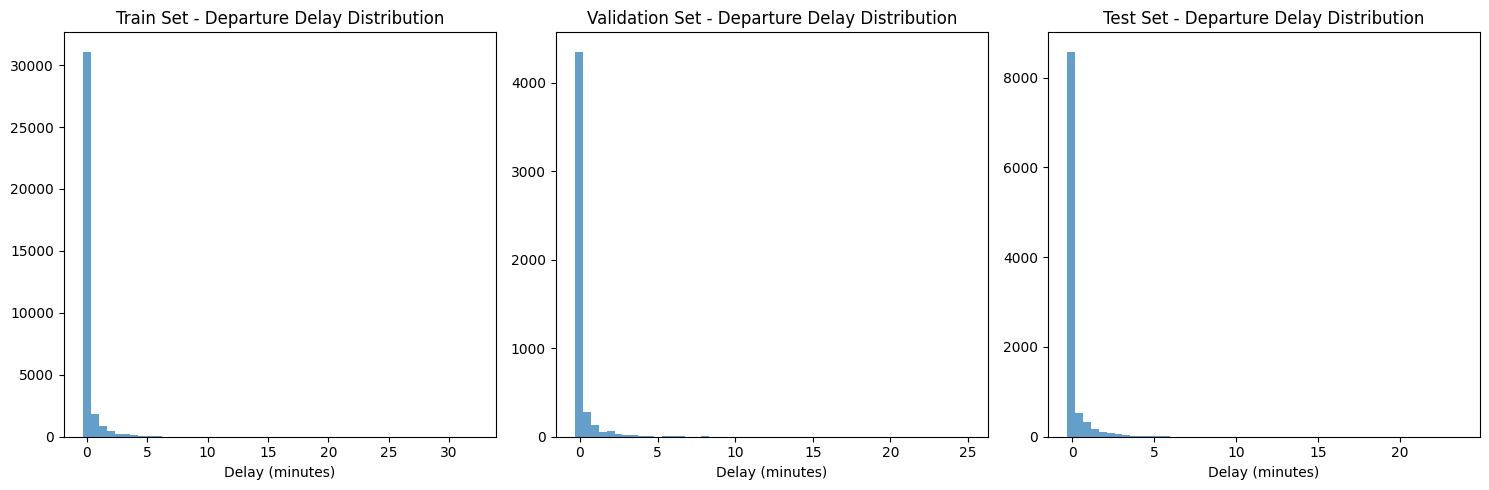

In [ ]:
# Create train-test-val split for deep learning (small sample for demonstration)
try:
    # Read a sample of the data
    dl_sample = pd.read_csv(os.path.join(DL_PROCESSED_PATH, 'dl_tabular_data.csv'), nrows=50000)
    
    # Convert date column back to datetime if needed
    if 'FL_DATE' in dl_sample.columns:
        dl_sample['FL_DATE'] = pd.to_datetime(dl_sample['FL_DATE'])
        
        # Create time-based splits
        train_data, val_data, test_data = time_based_split_dl(dl_sample)
        
        # Visualize the target distribution in each split
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.hist(train_data['DEP_DELAY'], bins=50, alpha=0.7)
        plt.title('Train Set - Departure Delay Distribution')
        plt.xlabel('Delay (minutes)')
        
        plt.subplot(132)
        plt.hist(val_data['DEP_DELAY'], bins=50, alpha=0.7)
        plt.title('Validation Set - Departure Delay Distribution')
        plt.xlabel('Delay (minutes)')
        
        plt.subplot(133)
        plt.hist(test_data['DEP_DELAY'], bins=50, alpha=0.7)
        plt.title('Test Set - Departure Delay Distribution')
        plt.xlabel('Delay (minutes)')
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error creating time-based splits: {e}")

## Creating Model-Ready Batches for Deep Learning Frameworks

In this section, we provide example code for formatting the preprocessed data into batches suitable for deep learning frameworks. This is a demonstration using a small sample, but the same approach can be applied to the full dataset.

In [ ]:
# Example: Create batches for a feed-forward neural network
def create_tabular_batches(df, target_col='DEP_DELAY', batch_size=32):
    """
    Create batches for training a tabular deep learning model
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col].values
    
    # Create batches
    n_samples = len(X)
    n_batches = n_samples // batch_size
    
    # Lists to store batches
    X_batches = []
    y_batches = []
    
    # Create batches
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        X_batches.append(X.iloc[start_idx:end_idx].values)
        y_batches.append(y[start_idx:end_idx])
    
    return X_batches, y_batches, X.columns.tolist()

In [ ]:
# Demonstration: Create tabular batches from a small sample
try:
    # Create batches from the train set
    if 'train_data' in locals():
        # Remove date column if present
        if 'FL_DATE' in train_data.columns:
            train_features = train_data.drop(columns=['FL_DATE'])
        else:
            train_features = train_data
            
        # Create batches
        X_batches, y_batches, feature_names = create_tabular_batches(train_features, batch_size=32)
        
        print(f"Created {len(X_batches)} batches for training")
        print(f"Batch shape: {X_batches[0].shape}")
        print(f"Target shape: {y_batches[0].shape}")
        
        # Show the first few feature names
        print("\nFirst 10 features:")
        for i, name in enumerate(feature_names[:10]):
            print(f"{i+1}. {name}")
        
except Exception as e:
    print(f"Error creating batches: {e}")

Created 1093 batches for training
Batch shape: (32, 31)
Target shape: (32,)

First 10 features:
1. ARR_DELAY
2. DELAY_DUE_NAS
3. TAXI_OUT
4. TAXI_IN
5. DELAY_DUE_CARRIER
6. DIVERTED
7. DEP_TIME
8. CRS_DEP_TIME
9. ELAPSED_TIME
10. WHEELS_OFF


## Summary of Deep Learning Preprocessing

The DL preprocessing pipeline has:

1. Added DL-specific engineered features optimized for neural networks
2. Created normalized time features (cyclic encoding using sin/cos)
3. Applied label encoding to categorical variables for embedding layers
4. Normalized numeric features for better convergence
5. Created sequence data for RNN/LSTM models
6. Implemented time-based train-test-validation splitting
7. Demonstrated batch creation for deep learning frameworks

This DL-ready dataset is optimized for both feedforward neural networks (tabular data) and recurrent neural networks (sequence data). The preprocessing enhances model convergence and provides appropriate formats for embedding layers commonly used in deep learning models for categorical variables.

In [ ]:
import pandas as pd

# Use raw strings for Windows paths
tabular_path = r'C:\Users\Electronica Care\Forecasting_Flights-DataScience\data\processed\dl_ready_flights\dl_tabular_data.csv'
ts_path = r'C:\Users\Electronica Care\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\per_flight_delay_ts.csv'

# Load datasets
tabular_df = pd.read_csv(tabular_path)
ts_df = pd.read_csv(ts_path)

# Display row counts
print(f"✅ Rows in dl_tabular_data.csv: {len(tabular_df):,}")
print(f"✅ Rows in per_flight_delay_ts.csv: {len(ts_df):,}")


✅ Rows in dl_tabular_data.csv: 600,000
✅ Rows in per_flight_delay_ts.csv: 2,470,267
